## Assignment 2

In [1]:
! pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.5 MB/s 


In [2]:
!pip install nltk

In [3]:
#load the packages
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
import pathlib
import shutil
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Embedding, LSTM, Dense,Bidirectional,GRU
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.utils.class_weight import compute_class_weight

from  IPython import display
from matplotlib import pyplot as plt

import tensorflow_addons as tfa

import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
import re                                                       
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [159]:
#loading the dataset, download data from colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assign2/Rumour_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [157]:
twitter_data = pd.read_csv('./Rumour_data/twitter_dataset.csv')
reddit_dataset = pd.read_csv('./Rumour_data/Extra_reddit_dataset.csv')

In [7]:
twitter_data.shape

(6634, 6)

In [8]:
reddit_dataset.shape

(2471, 6)

In [9]:
mergedData = pd.concat([twitter_data, reddit_dataset],ignore_index=True)

In [10]:
mergedData.shape

(9105, 6)

In [11]:
mergedData.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.81063e+17,-1,#4U9525: Robin names Andreas Lubitz as the cop...,germanwings-crash,-1
1,Reply,5.8107e+17,5.81063e+17,@thatjohn Have they named the pilot?,germanwings-crash,query
2,Reply,5.81064e+17,5.81063e+17,@thatjohn @mschenk,germanwings-crash,comment
3,Source,5.81386e+17,-1,RT @khjelmgaard: German media reporting #Andre...,germanwings-crash,-1
4,Reply,5.81576e+17,5.81386e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment


#Data Exploration and Pre-Processing

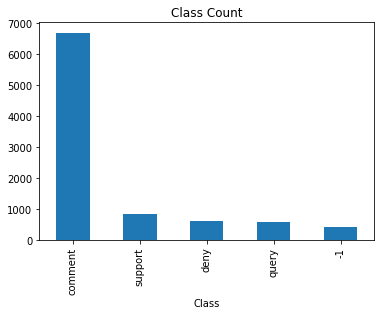

In [12]:
ax = mergedData.Class.value_counts(normalize=False).plot.bar()
plt.xlabel('Class')
plt.title('Class Count')
plt.show()

In [13]:
mergedData['Text'].value_counts()

[deleted]                                                                                                                                                        119
[removed]                                                                                                                                                         10
&gt;16 year olds can join the armed forces, should we allow them to vote?\n\n16 year olds can't be deployed in a warzone, so no.                                  10
Batman, you don't provide a quotation in which the author refutes Blackmore.  Yes, she says the events can be duplicated other ways **but not the sequence.**     10
Some overhyped actor, probably xD                                                                                                                                 10
                                                                                                                                                                ... 
@foxandfri

In [14]:
#remove the duplicate rows with '[deleted]' and '[removed]'

mergedData = mergedData[mergedData.Text != '[deleted]']
mergedData = mergedData[mergedData.Text != '[removed]']

In [15]:
mergedData['Text'].value_counts()

Batman, you don't provide a quotation in which the author refutes Blackmore.  Yes, she says the events can be duplicated other ways **but not the sequence.**          10
&gt;16 year olds can join the armed forces, should we allow them to vote?\n\n16 year olds can't be deployed in a warzone, so no.                                       10
Some overhyped actor, probably xD                                                                                                                                      10
Yes, because releasing the actual cost broken down would be a terrible political move for Trump. Why would he just randomly tell everyone how much the trips cost?     10
&gt;It is estimated                                                                                                                                                     9
                                                                                                                                                      

In [16]:
#Text Cleaning - pre processing regEx, removing punctuation, @user, special characters and stopped words
# for 'Text' and '' variable
mergedData["Text"]= mergedData["Text"].apply(lambda x: x.lower()) #conver words into lower case
mergedData["Text"] =  [re.sub(r'https?:\/\/.*[\r\n]*','', str(x)) for x in mergedData["Text"]] #remove hyperlinks
mergedData["Text"] =  [re.sub(r'@[a-z]+','', str(x)) for x in mergedData["Text"]] #remove @ from the text
mergedData["Text"] =  [re.sub(r'[^a-zA-Z\s]','', str(x)) for x in mergedData["Text"]] #remove special characters
mergedData["Text"] = mergedData["Text"].apply(lambda words: ' '.join(word.lower() for word in words.split() if len(word) > 1)) # remove single char

In [17]:
mergedData['Text']

0       robin names andreas lubitz as the copilot in t...
1                               have they named the pilot
2                                                        
3       rt german media reporting andreaslubitz had se...
4                fphantom crash mph hit concretewall dred
                              ...                        
9100    go kill deer or lets make it easy cow with you...
9101                           niacin is thats not iodine
9102                                       nascent iodine
9103                  likely full of strontium and cesium
9104    iodine is used for radiation poisoning funnily...
Name: Text, Length: 8976, dtype: object

In [18]:
mergedData.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.81063e+17,-1,robin names andreas lubitz as the copilot in t...,germanwings-crash,-1
1,Reply,5.8107e+17,5.81063e+17,have they named the pilot,germanwings-crash,query
2,Reply,5.81064e+17,5.81063e+17,,germanwings-crash,comment
3,Source,5.81386e+17,-1,rt german media reporting andreaslubitz had se...,germanwings-crash,-1
4,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewall dred,germanwings-crash,comment


In [19]:
stopped = stopwords.words("english")
stopped.remove('not')

In [20]:
for i in stopped:
  if("n'" in i):
    stopped.remove(i)

In [21]:
# remove stopwords
mergedData['Text'] = mergedData['Text'].apply(lambda words: ' '.join(word for word in words.split() if word not in stopped))

In [22]:
mergedData['Text']

0       robin names andreas lubitz copilot flight deck...
1                                             named pilot
2                                                        
3       rt german media reporting andreaslubitz seriou...
4                fphantom crash mph hit concretewall dred
                              ...                        
9100    go kill deer lets make easy cow bare hands eat...
9101                              niacin thats not iodine
9102                                       nascent iodine
9103                         likely full strontium cesium
9104       iodine used radiation poisoning funnily enough
Name: Text, Length: 8976, dtype: object

In [23]:
#Check for empty strings 
mergedData[mergedData['Text'] == ''].index

Int64Index([   2,  173,  361,  362,  366,  367,  473,  505,  522,  540,
            ...
            7587, 7735, 7785, 7828, 8289, 8302, 8316, 8325, 9001, 9020],
           dtype='int64', length=219)

In [24]:
# replace empty string with nan
mergedData['Text'].replace('', np.nan, inplace=True)

In [25]:
#check nan
mergedData.isnull().values.sum()

219

In [26]:
# drop NaN observations
mergedData = mergedData.dropna()

In [27]:
# check duplicates in ;Text' preserving first occrance
duplicate_data = mergedData[mergedData.duplicated('Text', keep='first')] 

In [28]:
duplicate_data

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
66,Reply,5.80377e+17,5.8034e+17,germanwings passenger plane crashes french alp...,germanwings-crash,comment
67,Reply,5.80344e+17,5.8034e+17,germanwings passenger plane crashes french alp...,germanwings-crash,comment
91,Reply,5.80321e+17,5.80319e+17,germanwings airbus crashes french alps near digne,germanwings-crash,support
93,Reply,5.8032e+17,5.80319e+17,rt germanwings airbus crashes french alps near...,germanwings-crash,support
95,Reply,5.80321e+17,5.80319e+17,germanwings airbus crashes french alps near digne,germanwings-crash,support
...,...,...,...,...,...,...
9099,Reply,e3bf4jc,934q6t,plenty red meat easily eaten raw even chimps a...,None,comment
9100,Reply,e3bg540,934q6t,go kill deer lets make easy cow bare hands eat...,None,comment
9102,Reply,e3cgyvc,934q6t,nascent iodine,None,comment
9103,Reply,e3b7gdl,934q6t,likely full strontium cesium,None,comment


In [29]:
# filter out duplicate observations except Source Type
duplicate_data = duplicate_data[duplicate_data['Type'] != "Source"]

In [30]:
# drop duplicate observations
mergedData = mergedData[mergedData.apply(lambda x: x.values.tolist() not in duplicate_data.values.tolist(), axis=1)]

In [31]:
mergedData = mergedData.reset_index(drop=True)

In [32]:
mergedData

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.81063e+17,-1,robin names andreas lubitz copilot flight deck...,germanwings-crash,-1
1,Reply,5.8107e+17,5.81063e+17,named pilot,germanwings-crash,query
2,Source,5.81386e+17,-1,rt german media reporting andreaslubitz seriou...,germanwings-crash,-1
3,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewall dred,germanwings-crash,comment
4,Reply,5.82048e+17,5.81386e+17,ers link prove intentionally set kill,germanwings-crash,comment
...,...,...,...,...,...,...
6602,Reply,e3bn1v6,934q6t,anyone dr enuf,None,comment
6603,Reply,e3b5lyp,934q6t,could also eating seaweed thats radiated fukus...,None,comment
6604,Reply,e3b9yiy,934q6t,nascent iodine best,None,comment
6605,Reply,e3bsdee,934q6t,tried drops sublingually tearing tongue ill gi...,None,comment


In [33]:
#tokenize the sentecnces into words
# apply stemmer on tokenized words
#join back the wors into sentence

porter_stemmer = PorterStemmer()

def porter_stem_text(text):
    words = text.split()
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

mergedData["Text"] = mergedData["Text"].apply(porter_stem_text)

In [34]:
mergedData

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.81063e+17,-1,robin name andrea lubitz copilot flight deck c...,germanwings-crash,-1
1,Reply,5.8107e+17,5.81063e+17,name pilot,germanwings-crash,query
2,Source,5.81386e+17,-1,rt german media report andreaslubitz seriou de...,germanwings-crash,-1
3,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewal dred,germanwings-crash,comment
4,Reply,5.82048e+17,5.81386e+17,er link prove intent set kill,germanwings-crash,comment
...,...,...,...,...,...,...
6602,Reply,e3bn1v6,934q6t,anyon dr enuf,None,comment
6603,Reply,e3b5lyp,934q6t,could also eat seawe that radiat fukushima,None,comment
6604,Reply,e3b9yiy,934q6t,nascent iodin best,None,comment
6605,Reply,e3bsdee,934q6t,tri drop sublingu tear tongu ill give solut sh...,None,comment


In [35]:
#Data cleaning and pre processing
#creating a new column to seggregate source and add source Text against each reply which have the same Msg_ID	and Source_Msg_ID

In [36]:
Type_Source = []
for i, row in mergedData.iterrows():
  if row['Type'] == 'Source':
    new_source = row['Text']
    msg_id = row['Msg_ID']
  if msg_id == row['Source_Msg_ID']:
    Type_Source.append(new_source)

In [37]:
len(Type_Source)

6186

In [38]:
mergedData = mergedData.loc[mergedData['Type'] != 'Source']

In [39]:
len(mergedData)

6186

In [40]:
mergedData['New_Source'] = Type_Source

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
mergedData

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,New_Source
1,Reply,5.8107e+17,5.81063e+17,name pilot,germanwings-crash,query,robin name andrea lubitz copilot flight deck c...
3,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewal dred,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
4,Reply,5.82048e+17,5.81386e+17,er link prove intent set kill,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
5,Reply,5.82206e+17,5.81386e+17,sure germanw copilot andreaslubitz newmot dead...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
6,Reply,5.81573e+17,5.81386e+17,andreaslubitz germanw dred splitup girlfriend ...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
...,...,...,...,...,...,...,...
6602,Reply,e3bn1v6,934q6t,anyon dr enuf,None,comment,iodin increas iq essenti part human diet yet a...
6603,Reply,e3b5lyp,934q6t,could also eat seawe that radiat fukushima,None,comment,iodin increas iq essenti part human diet yet a...
6604,Reply,e3b9yiy,934q6t,nascent iodin best,None,comment,iodin increas iq essenti part human diet yet a...
6605,Reply,e3bsdee,934q6t,tri drop sublingu tear tongu ill give solut sh...,None,comment,iodin increas iq essenti part human diet yet a...


In [42]:
mergedData = mergedData.reset_index(drop=True)

In [43]:
mergedData

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,New_Source
0,Reply,5.8107e+17,5.81063e+17,name pilot,germanwings-crash,query,robin name andrea lubitz copilot flight deck c...
1,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewal dred,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
2,Reply,5.82048e+17,5.81386e+17,er link prove intent set kill,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
3,Reply,5.82206e+17,5.81386e+17,sure germanw copilot andreaslubitz newmot dead...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
4,Reply,5.81573e+17,5.81386e+17,andreaslubitz germanw dred splitup girlfriend ...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
...,...,...,...,...,...,...,...
6181,Reply,e3bn1v6,934q6t,anyon dr enuf,None,comment,iodin increas iq essenti part human diet yet a...
6182,Reply,e3b5lyp,934q6t,could also eat seawe that radiat fukushima,None,comment,iodin increas iq essenti part human diet yet a...
6183,Reply,e3b9yiy,934q6t,nascent iodin best,None,comment,iodin increas iq essenti part human diet yet a...
6184,Reply,e3bsdee,934q6t,tri drop sublingu tear tongu ill give solut sh...,None,comment,iodin increas iq essenti part human diet yet a...


In [44]:
#Check for null/missing values
mergedData.isnull().sum()

Type             0
Msg_ID           0
Source_Msg_ID    0
Text             0
Topic            0
Class            0
New_Source       0
dtype: int64

In [45]:
cleaned_df = mergedData

In [46]:
cleaned_df

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,New_Source
0,Reply,5.8107e+17,5.81063e+17,name pilot,germanwings-crash,query,robin name andrea lubitz copilot flight deck c...
1,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewal dred,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
2,Reply,5.82048e+17,5.81386e+17,er link prove intent set kill,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
3,Reply,5.82206e+17,5.81386e+17,sure germanw copilot andreaslubitz newmot dead...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
4,Reply,5.81573e+17,5.81386e+17,andreaslubitz germanw dred splitup girlfriend ...,germanwings-crash,comment,rt german media report andreaslubitz seriou de...
...,...,...,...,...,...,...,...
6181,Reply,e3bn1v6,934q6t,anyon dr enuf,None,comment,iodin increas iq essenti part human diet yet a...
6182,Reply,e3b5lyp,934q6t,could also eat seawe that radiat fukushima,None,comment,iodin increas iq essenti part human diet yet a...
6183,Reply,e3b9yiy,934q6t,nascent iodin best,None,comment,iodin increas iq essenti part human diet yet a...
6184,Reply,e3bsdee,934q6t,tri drop sublingu tear tongu ill give solut sh...,None,comment,iodin increas iq essenti part human diet yet a...


I will be using the Text and New_Source as our two inputs(x) and Class as our y

In [47]:
#encoding  Categorical to numerical
# encoding class variable
encoder = LabelEncoder()
cleaned_df.insert(5,'Encoded_Class',encoder.fit_transform(cleaned_df['Class']))

In [48]:
cleaned_df

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Encoded_Class,Class,New_Source
0,Reply,5.8107e+17,5.81063e+17,name pilot,germanwings-crash,2,query,robin name andrea lubitz copilot flight deck c...
1,Reply,5.81576e+17,5.81386e+17,fphantom crash mph hit concretewal dred,germanwings-crash,0,comment,rt german media report andreaslubitz seriou de...
2,Reply,5.82048e+17,5.81386e+17,er link prove intent set kill,germanwings-crash,0,comment,rt german media report andreaslubitz seriou de...
3,Reply,5.82206e+17,5.81386e+17,sure germanw copilot andreaslubitz newmot dead...,germanwings-crash,0,comment,rt german media report andreaslubitz seriou de...
4,Reply,5.81573e+17,5.81386e+17,andreaslubitz germanw dred splitup girlfriend ...,germanwings-crash,0,comment,rt german media report andreaslubitz seriou de...
...,...,...,...,...,...,...,...,...
6181,Reply,e3bn1v6,934q6t,anyon dr enuf,None,0,comment,iodin increas iq essenti part human diet yet a...
6182,Reply,e3b5lyp,934q6t,could also eat seawe that radiat fukushima,None,0,comment,iodin increas iq essenti part human diet yet a...
6183,Reply,e3b9yiy,934q6t,nascent iodin best,None,0,comment,iodin increas iq essenti part human diet yet a...
6184,Reply,e3bsdee,934q6t,tri drop sublingu tear tongu ill give solut sh...,None,0,comment,iodin increas iq essenti part human diet yet a...


In [49]:
cleaned_df['Class'].value_counts()

comment    4510
support     646
query       519
deny        511
Name: Class, dtype: int64

In [50]:
cleaned_df['Encoded_Class'].value_counts()

0    4510
3     646
2     519
1     511
Name: Encoded_Class, dtype: int64

In [51]:
# Early Stopping
# early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [52]:
#Learning Curve Plotter
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  plt.figure(figsize=(12,8))
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))
    
    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

## Generating the task vocabulary
 using the keras Tokenizer to generate a vocabulary for the data

In [53]:
# tokenizing and generating sequence
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(cleaned_df['Text'].values)
X1 = tokenizer_obj.texts_to_sequences(cleaned_df['Text'].values)

tokenizer_obj.fit_on_texts(cleaned_df['New_Source'].values)
X2 = tokenizer_obj.texts_to_sequences(cleaned_df['New_Source'].values)


In [54]:
word_index = tokenizer_obj.word_index
print("unique_tokens - "+str(len(word_index)))

vocab_size = len(tokenizer_obj.word_index) + 1
print('vocabulary_size - '+str(vocab_size))

unique_tokens - 8109
vocabulary_size - 8110


In [55]:
#pad each sequence to the same length
X1 = pad_sequences(X1,maxlen= 50)
X2 = pad_sequences(X2,maxlen= 50)


In [56]:
X1[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       3794,  242, 3795,  981, 3796, 1659], dtype=int32)

In [57]:
X2[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   92,  355,  105,    8, 1447,
         83,  440,  661,  557,  196,  461], dtype=int32)

In [58]:
X1.shape

(6186, 50)

In [59]:
X2.shape

(6186, 50)

In [60]:
#label encoding the Y target
Y = pd.get_dummies(cleaned_df['Encoded_Class'])

In [61]:
Y.shape

(6186, 4)

# Spliiting up Data
Split the dataset into train, test and validation

In [62]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size = 0.3, stratify = Y)
X1_train, X1_val, X2_train, X2_val, Y_train, Y_val = train_test_split(X1_train, X2_train,  Y_train, test_size = 0.25, stratify = Y_train)

In [63]:
print('Shape of X1_train:',X1_train.shape,'Shape of Y_train:',Y_train.shape)
print('Shape of X2_train:',X2_train.shape,'Shape of Y_train:',Y_train.shape)
print('Shape of X1_val:',X1_val.shape,'Shape of Y_val:',Y_val.shape)
print('Shape of X2_val:',X2_val.shape,'Shape of Y_val:',Y_val.shape)
print('Shape of X1_test:',X1_test.shape,'Shape of Y_test:',Y_test.shape)
print('Shape of X2_test:',X2_test.shape,'Shape of Y_test:',Y_test.shape)

Shape of X1_train: (3247, 50) Shape of Y_train: (3247, 4)
Shape of X2_train: (3247, 50) Shape of Y_train: (3247, 4)
Shape of X1_val: (1083, 50) Shape of Y_val: (1083, 4)
Shape of X2_val: (1083, 50) Shape of Y_val: (1083, 4)
Shape of X1_test: (1856, 50) Shape of Y_test: (1856, 4)
Shape of X2_test: (1856, 50) Shape of Y_test: (1856, 4)


In [64]:
X1_train

array([[   0,    0,    0, ...,    0,  101,   41],
       [   0,    0,    0, ...,  171,   86,  127],
       [   0,    0,    0, ...,   35,    5,  365],
       ...,
       [   0,    0,    0, ...,  360,  323,   49],
       [   0,    0,    0, ...,   76,   29, 6135],
       [   0,    0,    0, ...,  107,   32,  239]], dtype=int32)

In [65]:
Y_test = Y_test.idxmax(axis=1)

## Evaluation Matric
I chose macro average F1 score as my performance matric because my data is highly imbalanced. I have chosen Accuracy as my another performance matrix to see how well my model perform and see the TP,FP, TN, FN

In [66]:
# Performance Matric
def define_metric():
  metric = [tfa.metrics.F1Score(num_classes=4,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
  return metric

In [67]:
# confusion matrix plot
def plot_Confusion_Matric(labels, predictions):
  conf = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,6))
  sns.heatmap(conf, annot=True, fmt="d")
  plt.title('Confusion - Matrics @{:.2f}')
  plt.ylabel('Actual - label')
  plt.xlabel('Predicted - label')

## Baseline Model
# No Transfer Learning
I have selected simple LSTM model without transfer learning

In [68]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

In [69]:
# learning rate decay scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [70]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

embedding_dim = 50

reply_text_inp = Input(shape=(X1_train.shape[1]), name='reply_text_inp')
new_source_inp = Input(shape=(X2_train.shape[1]), name='new_source_inp')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length = X1_train.shape[1] , trainable=True)

x1 = embedding_layer(reply_text_inp)
x2 = embedding_layer(new_source_inp)

x = tf.keras.layers.concatenate([x1, x2])

x = LSTM(32, return_sequences=False)(x)

output = Dense(4, activation ='softmax', name ='output')(x)

model_WL = Model(inputs=[reply_text_inp, new_source_inp], outputs = [output])

model_WL.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics = define_metric())

print(model_WL.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_text_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
new_source_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 50)       405500      reply_text_inp[0][0]             
                                                                 new_source_inp[0][0]             
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 100)      0           embedding[0][0]              

In [71]:
batch_size = 32
m_histories = {}
EPOCH = 50

In [72]:
m_histories['WL'] =  model_WL.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = EPOCH, batch_size=batch_size,callbacks= [early_stopping])

Epoch 1/50
102/102 [==============================] - 9s 21ms/step - loss: 0.9428 - f1_score: 0.2209 - accuracy: 0.7200 - val_loss: 0.8716 - val_f1_score: 0.2109 - val_accuracy: 0.7295
Epoch 2/50
102/102 [==============================] - 2s 15ms/step - loss: 0.8340 - f1_score: 0.2108 - accuracy: 0.7290 - val_loss: 0.8474 - val_f1_score: 0.2109 - val_accuracy: 0.7295
Epoch 3/50
102/102 [==============================] - 2s 16ms/step - loss: 0.6896 - f1_score: 0.3200 - accuracy: 0.7475 - val_loss: 0.8663 - val_f1_score: 0.2638 - val_accuracy: 0.7239
Epoch 4/50
102/102 [==============================] - 2s 16ms/step - loss: 0.4939 - f1_score: 0.5794 - accuracy: 0.8192 - val_loss: 0.9464 - val_f1_score: 0.3396 - val_accuracy: 0.7091
Epoch 5/50
102/102 [==============================] - 1s 15ms/step - loss: 0.3398 - f1_score: 0.7504 - accuracy: 0.8827 - val_loss: 1.0986 - val_f1_score: 0.3481 - val_accuracy: 0.6805
Epoch 6/50
102/102 [==============================] - 2s 15ms/step - loss: 

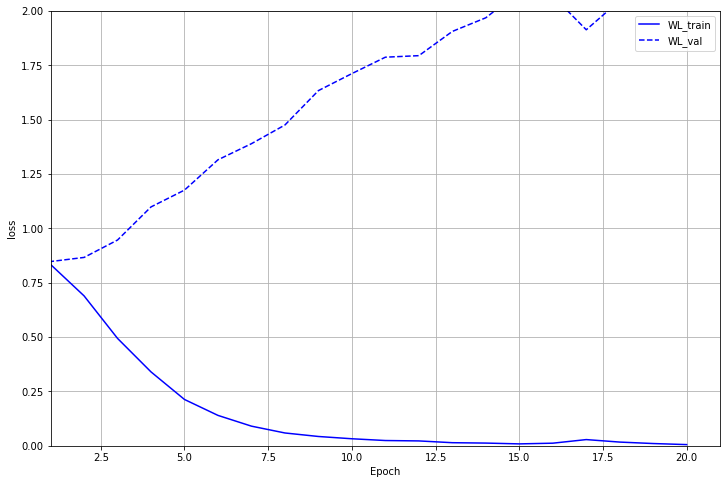

In [73]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

It can be clearly see that, our model is overfitting.

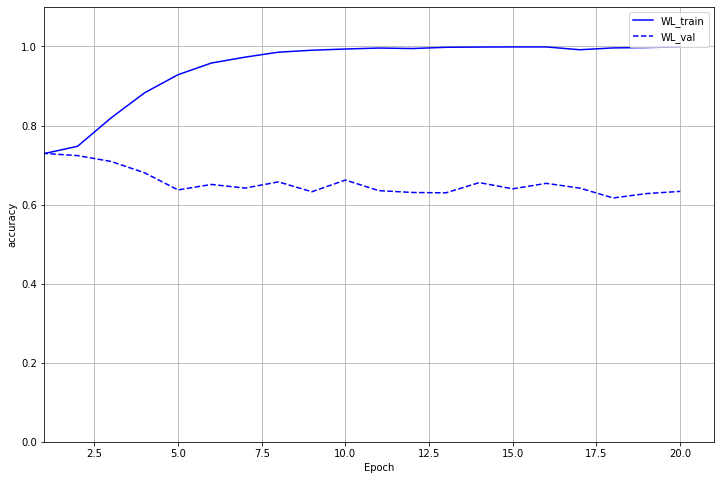

In [74]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [75]:
Y_predict_WL = model_WL.predict([X1_test,X2_test])
Y_predict_WL = np.argmax(Y_predict_WL, axis = 1)

print(classification_report(Y_test,Y_predict_WL))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1353
           1       0.19      0.16      0.17       153
           2       0.16      0.10      0.12       156
           3       0.24      0.21      0.22       194

    accuracy                           0.65      1856
   macro avg       0.34      0.32      0.33      1856
weighted avg       0.61      0.65      0.63      1856



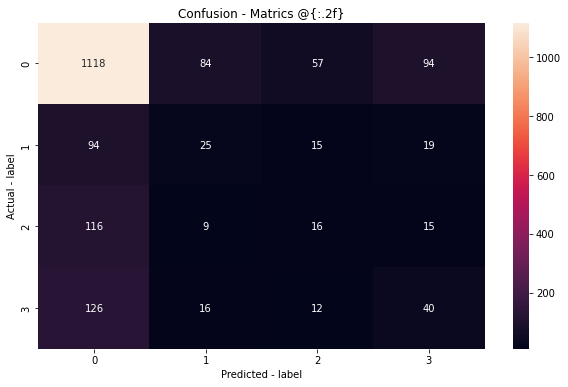

In [76]:
import seaborn as sns
plot_Confusion_Matric(Y_test,Y_predict_WL)

# Baseline Model with Class Weights & Dropouts

In [77]:
embedding_dim = 100

reply_text_inp = Input(shape=(X1_train.shape[1]), name='reply_text_inp')
new_source_inp = Input(shape=(X2_train.shape[1]), name='new_source_inp')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length = X1_train.shape[1] , trainable=True)

x1 = embedding_layer(reply_text_inp)
x2 = embedding_layer(new_source_inp)

x = tf.keras.layers.concatenate([x1, x2])

x = SpatialDropout1D(0.2)(x) #add dropout layer of 0.2
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)

output = Dense(4, activation ='softmax', name ='output')(x)

model_WL_dropout = Model(inputs=[reply_text_inp, new_source_inp], outputs = [output])

model_WL_dropout.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics = define_metric())

print(model_WL_dropout.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_text_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
new_source_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      811000      reply_text_inp[0][0]             
                                                                 new_source_inp[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 50, 200)      0           embedding_1[0][0]          

In [78]:
# compute class weights
class_W = compute_class_weight('balanced', np.unique(cleaned_df['Class']), cleaned_df['Class'])
class_W = dict(enumerate(class_W))

In [79]:
class_W

{0: 0.34290465631929046,
 1: 3.0264187866927594,
 2: 2.979768786127168,
 3: 2.3939628482972135}

In [80]:
batch_size = 32
m_histories = {}
EPOCH = 50

In [81]:
m_histories['drop_class_weight'] = model_WL_dropout.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = EPOCH, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_W)

Epoch 1/50
102/102 [==============================] - 33s 298ms/step - loss: 1.3784 - f1_score: 0.2325 - accuracy: 0.3486 - val_loss: 1.3162 - val_f1_score: 0.3204 - val_accuracy: 0.5540
Epoch 2/50
102/102 [==============================] - 30s 298ms/step - loss: 1.2777 - f1_score: 0.3716 - accuracy: 0.4974 - val_loss: 1.3018 - val_f1_score: 0.3112 - val_accuracy: 0.3897
Epoch 3/50
102/102 [==============================] - 30s 297ms/step - loss: 1.0203 - f1_score: 0.4603 - accuracy: 0.5343 - val_loss: 1.1298 - val_f1_score: 0.3583 - val_accuracy: 0.5060
Epoch 4/50
102/102 [==============================] - 30s 293ms/step - loss: 0.7278 - f1_score: 0.5763 - accuracy: 0.6489 - val_loss: 1.2535 - val_f1_score: 0.3427 - val_accuracy: 0.4561
Epoch 5/50
102/102 [==============================] - 30s 294ms/step - loss: 0.4940 - f1_score: 0.6927 - accuracy: 0.7635 - val_loss: 1.3156 - val_f1_score: 0.3663 - val_accuracy: 0.4968
Epoch 6/50
102/102 [==============================] - 30s 294ms/s

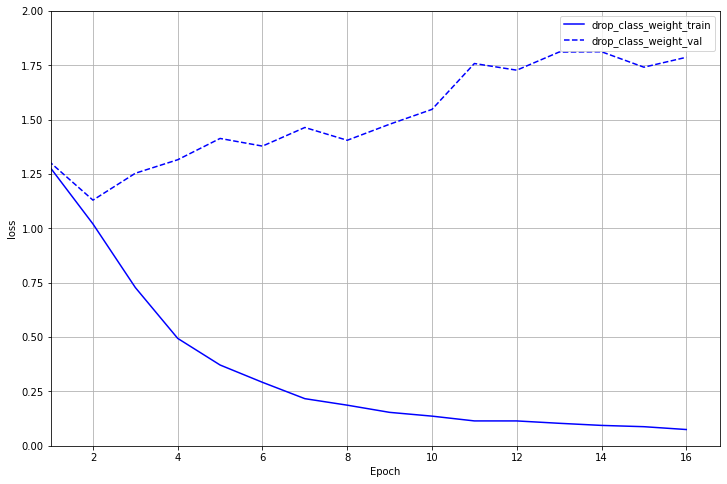

In [82]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

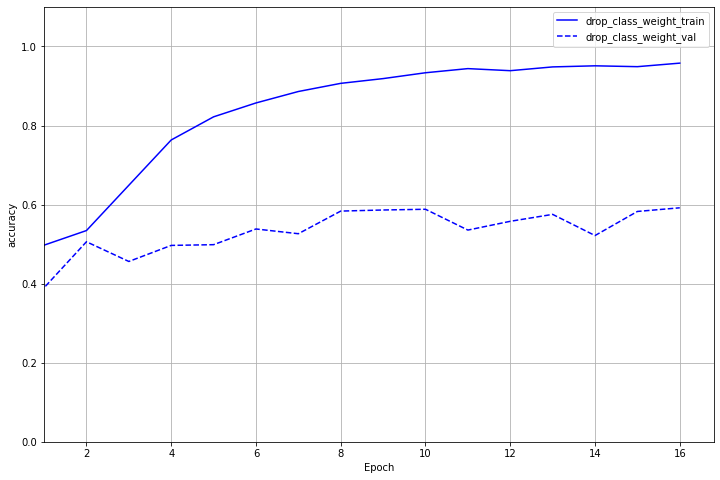

In [83]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [86]:
Y_predict_drop_CW = model_WL_dropout.predict([X1_test,X2_test])
Y_predict_drop_CW = np.argmax(Y_predict_drop_CW, axis = 1)
print(classification_report(Y_test,Y_predict_drop_CW))

              precision    recall  f1-score   support

           0       0.81      0.58      0.67      1353
           1       0.21      0.39      0.27       153
           2       0.17      0.35      0.23       156
           3       0.22      0.31      0.26       194

    accuracy                           0.52      1856
   macro avg       0.35      0.41      0.36      1856
weighted avg       0.64      0.52      0.56      1856



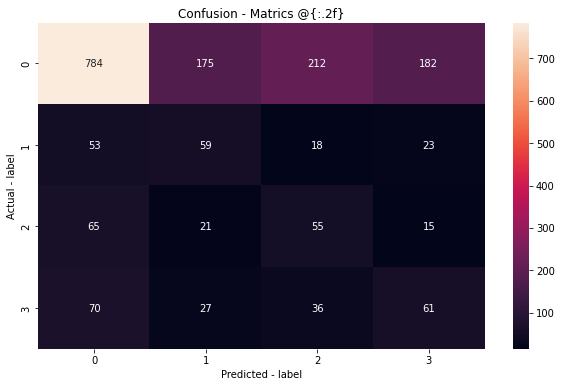

In [90]:
plot_Confusion_Matric(Y_test,Y_predict_drop_CW)

# Basline Model with Transfer Learning

as my Basline model didn't perform well with no transfer learning, i am going to implement model with GloVe word embeddings transfer learning

In [137]:
!cp /content/drive/MyDrive/Assign2/glove.twitter.27B.100d.txt .

In [139]:
file = open('glove.twitter.27B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

Transfere the GloVe embedding vectors to your embedding matrix. This will be done by mapping our task vocabulary to the GloVe vocabulary.

In [140]:
embedding_dim = 100
E_T = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_T[i] = embedding_vector

In [132]:
#model with transfer learning

reply_text_inp = Input(shape=(X1_train.shape[1]), name='reply_text_inp')
new_source_inp = Input(shape=(X2_train.shape[1]), name='new_source_inp')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[E_T],
                            input_length = X1.shape[1] , trainable=False)

x1 = embedding_layer(reply_text_inp)
x2 = embedding_layer(new_source_inp)

x = tf.keras.layers.concatenate([x1, x2])

# x = SpatialDropout1D(0.2)(x) #add dropout layer of 0.2
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)

output = Dense(4, activation ='softmax', name ='output')(x)

model_TL_dropout = Model(inputs=[reply_text_inp, new_source_inp], outputs = [output])

model_TL_dropout.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics = define_metric())

print(model_TL_dropout.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_text_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
new_source_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 50)       405500      reply_text_inp[0][0]             
                                                                 new_source_inp[0][0]             
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 50, 100)      0           embedding_7[0][0]          

In [133]:
batch_size = 64
EPOCH = 50
m_histories['TL_drop_weight'] =  model_TL_dropout.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = EPOCH, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_W)

Epoch 1/50
51/51 [==============================] - 19s 299ms/step - loss: 1.3981 - f1_score: 0.2179 - accuracy: 0.3104 - val_loss: 1.4099 - val_f1_score: 0.1961 - val_accuracy: 0.2308
Epoch 2/50
51/51 [==============================] - 14s 282ms/step - loss: 1.3754 - f1_score: 0.2420 - accuracy: 0.3348 - val_loss: 1.4168 - val_f1_score: 0.2014 - val_accuracy: 0.2198
Epoch 3/50
51/51 [==============================] - 15s 293ms/step - loss: 1.3675 - f1_score: 0.2252 - accuracy: 0.2624 - val_loss: 1.3736 - val_f1_score: 0.2332 - val_accuracy: 0.2909
Epoch 4/50
51/51 [==============================] - 15s 289ms/step - loss: 1.3482 - f1_score: 0.2549 - accuracy: 0.3280 - val_loss: 1.3740 - val_f1_score: 0.2268 - val_accuracy: 0.2613
Epoch 5/50
51/51 [==============================] - 14s 281ms/step - loss: 1.3403 - f1_score: 0.2688 - accuracy: 0.3342 - val_loss: 1.3769 - val_f1_score: 0.2319 - val_accuracy: 0.2798
Epoch 6/50
51/51 [==============================] - 14s 279ms/step - loss: 

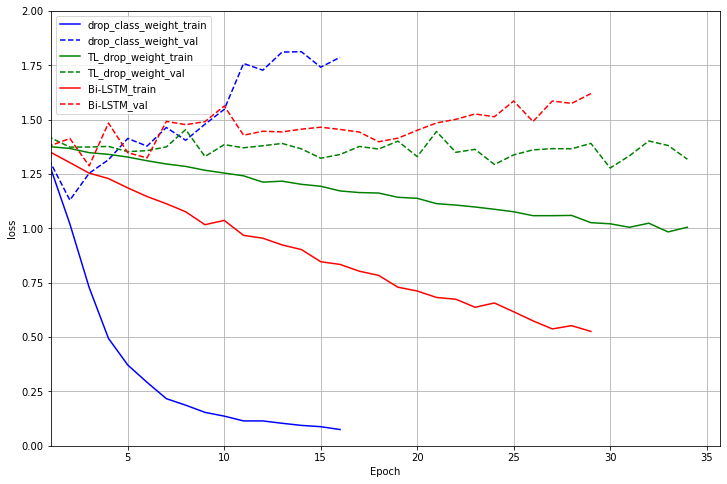

In [134]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

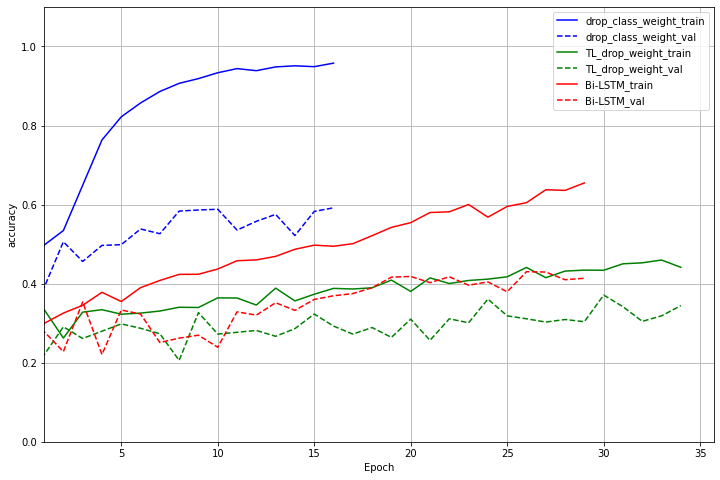

In [135]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [136]:
Y_pred_TL_drop_weight = model_TL_dropout.predict([X1_test,X2_test])
Y_pred_TL_drop_weight = np.argmax(Y_pred_TL_drop_weight, axis = 1)
print(classification_report(Y_test,Y_pred_TL_drop_weight))

              precision    recall  f1-score   support

           0       0.77      0.32      0.46      1353
           1       0.19      0.28      0.23       153
           2       0.13      0.37      0.20       156
           3       0.14      0.44      0.21       194

    accuracy                           0.34      1856
   macro avg       0.31      0.35      0.27      1856
weighted avg       0.60      0.34      0.39      1856



It can be seen that baseline model LSTM with transfer learning and class weights has worked quite better than with no transfer learning.

As my model still hasn't performed well and haven't achieved good accuracy and F1 score, I am going to use bidirectional LSTM

In [144]:
#Bidirectional LSTM model with transfer learning

reply_text_inp = Input(shape=(X1_train.shape[1]), name='reply_text_inp')
new_source_inp = Input(shape=(X2_train.shape[1]), name='new_source_inp')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[E_T],
                            input_length = X1.shape[1] , trainable = True)

x1 = embedding_layer(reply_text_inp)
x2 = embedding_layer(new_source_inp)

x = tf.keras.layers.concatenate([x1, x2])

x = Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))(x)
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)
# x = Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2, return_sequences=False))(x)

output = Dense(4, activation ='softmax', name ='output')(x)

model_Bi_LSTM = Model(inputs=[reply_text_inp, new_source_inp], outputs = [output])

model_Bi_LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics = define_metric())

print(model_Bi_LSTM.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_text_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
new_source_inp (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 50, 100)      811000      reply_text_inp[0][0]             
                                                                 new_source_inp[0][0]             
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 50, 200)      0           embedding_10[0][0]        

In [145]:
batch_size = 64
EPOCH = 50
m_histories['Bi-LSTM'] =  model_Bi_LSTM.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = EPOCH, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_W)

Epoch 1/50
51/51 [==============================] - 55s 915ms/step - loss: 1.3866 - f1_score: 0.2001 - accuracy: 0.2445 - val_loss: 1.3635 - val_f1_score: 0.2538 - val_accuracy: 0.3029
Epoch 2/50
51/51 [==============================] - 45s 887ms/step - loss: 1.3340 - f1_score: 0.2482 - accuracy: 0.2873 - val_loss: 1.3636 - val_f1_score: 0.2013 - val_accuracy: 0.2096
Epoch 3/50
51/51 [==============================] - 45s 890ms/step - loss: 1.2777 - f1_score: 0.2874 - accuracy: 0.3298 - val_loss: 1.3763 - val_f1_score: 0.2297 - val_accuracy: 0.2484
Epoch 4/50
51/51 [==============================] - 45s 885ms/step - loss: 1.1834 - f1_score: 0.3233 - accuracy: 0.3502 - val_loss: 1.3648 - val_f1_score: 0.2602 - val_accuracy: 0.3195
Epoch 5/50
51/51 [==============================] - 45s 891ms/step - loss: 1.1035 - f1_score: 0.3556 - accuracy: 0.3933 - val_loss: 1.3417 - val_f1_score: 0.2815 - val_accuracy: 0.3592
Epoch 6/50
51/51 [==============================] - 45s 892ms/step - loss: 

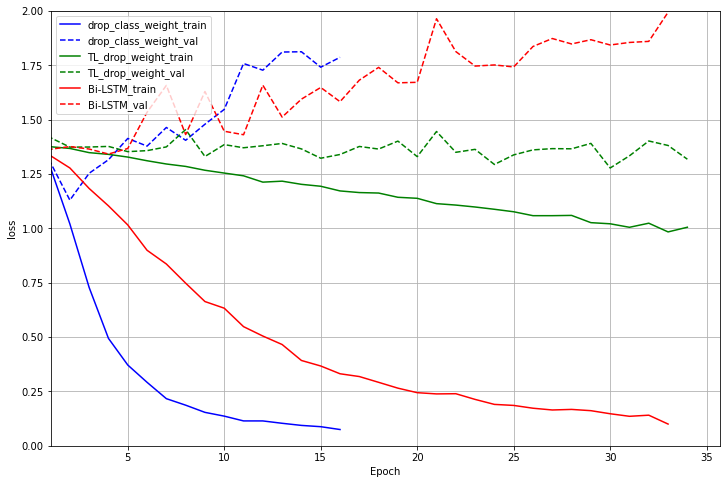

In [146]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

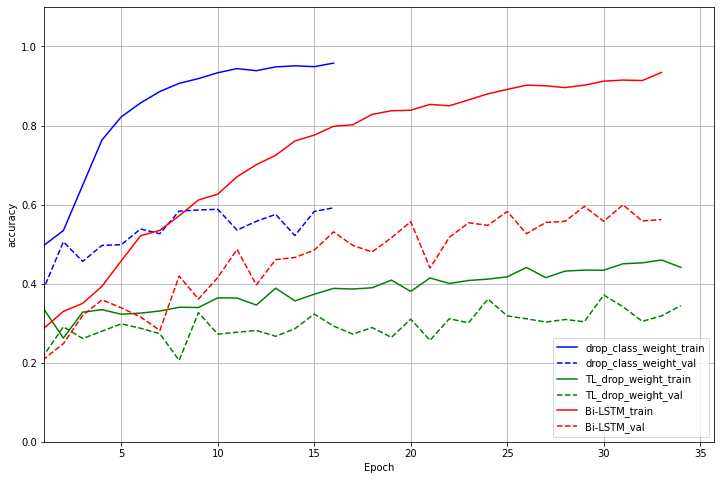

In [147]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [148]:
Y_predict_BI = model_Bi_LSTM.predict([X1_test,X2_test])
Y_predict_BI = np.argmax(Y_predict_BI, axis = 1)

print(classification_report(Y_test,Y_predict_BI))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1353
           1       0.20      0.35      0.25       153
           2       0.16      0.25      0.20       156
           3       0.23      0.28      0.25       194

    accuracy                           0.55      1856
   macro avg       0.34      0.38      0.35      1856
weighted avg       0.63      0.55      0.58      1856



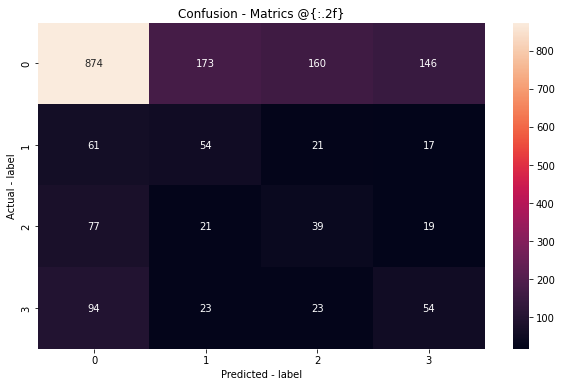

In [149]:
plot_Confusion_Matric(Y_test,Y_predict_BI)

Bidirectional LSTM has worked quite well.

In [200]:
model_Bi_LSTM.save("model_BTL.h5")
!cp -R ./model_BTL.h5 /content/drive/MyDrive/Assign2/

Test on Independent Dataset

In [229]:
test_data = pd.read_excel('/content/drive/MyDrive/Assign2/test_data.xlsx')

In [230]:
test_data.shape

(49, 6)

In [231]:
test_data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5810001,-1,#4AW: I promised not to raise taxes on anyone ...,None,-1
1,Reply,5810001,5810001,R @opts There should be no pissed off blue col...,None,comment
2,Reply,5810001,5810001,"Thank you, Mr President. You have my full supp...",None,support
3,Source,5810002,-1,#ASDF: Indian president is going to reduce the...,None,-1
4,Reply,5810002,5810002,a 1 @SDRT I don't think so.,None,deny


In [232]:
#Text Cleaning - pre processing regEx, removing punctuation, @user, special characters and stopped words
# for 'Text' and '' variable
test_data["Text"]= test_data["Text"].apply(lambda x: x.lower()) #conver words into lower case
test_data["Text"] =  [re.sub(r'https?:\/\/.*[\r\n]*','', str(x)) for x in test_data["Text"]] #remove hyperlinks
test_data["Text"] =  [re.sub(r'@[a-z]+','', str(x)) for x in test_data["Text"]] #remove @ from the text
test_data["Text"] =  [re.sub(r'[^a-zA-Z\s]','', str(x)) for x in test_data["Text"]] #remove special characters
test_data["Text"] = test_data["Text"].apply(lambda words: ' '.join(word.lower() for word in words.split() if len(word) > 1)) # remove single char

In [233]:
stopped = stopwords.words("english")
stopped.remove('not')

for i in stopped:
  if("n'" in i):
    stopped.remove(i)

In [234]:
# remove stopwords
test_data['Text'] = test_data['Text'].apply(lambda words: ' '.join(word for word in words.split() if word not in stopped))

In [235]:
porter_stemmer = PorterStemmer()

def porter_stem_text(text):
    words = text.split()
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [236]:
test_data["Text"] = test_data["Text"].apply(porter_stem_text)

In [237]:
test_data.shape

(49, 6)

In [238]:
Type_Source = []
for i, row in test_data.iterrows():
  if row['Type'] == 'Source':
    new_source = row['Text']
    msg_id = row['Msg_ID']
  if msg_id == row['Source_Msg_ID']:
    Type_Source.append(new_source)

In [239]:
len(Type_Source)

46

In [240]:
test_data = test_data.loc[test_data['Type'] != 'Source']

In [211]:
len(test_data)

46

In [241]:
test_data['New_Source'] = Type_Source

test_data = test_data.reset_index(drop=True)

In [242]:
test_data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,New_Source
0,Reply,5810001,5810001,piss blue collar worker comment sectiond,None,comment,aw promis not rais tax anyon make year
1,Reply,5810001,5810001,thank mr presid full support,None,support,aw promis not rais tax anyon make year
2,Reply,5810002,5810002,dont think,None,deny,asdf indian presid go reduc oil price
3,Reply,5810002,5810002,fake news,None,deny,asdf indian presid go reduc oil price
4,Reply,5810002,5810002,aa price reducton help increas economi,None,comment,asdf indian presid go reduc oil price


In [214]:
# cleaned_test = test_data

In [243]:
encoder = LabelEncoder()
test_data.insert(5,'Encoded_Class',encoder.fit_transform(test_data['Class']))

In [244]:
tokenizer_obj.fit_on_texts(test_data['Text'].values)
X3 = tokenizer_obj.texts_to_sequences(test_data['Text'].values)

tokenizer_obj.fit_on_texts(test_data['New_Source'].values)
X4 = tokenizer_obj.texts_to_sequences(test_data['New_Source'].values)

In [245]:
word_index = tokenizer_obj.word_index
print("unique_tokens - "+str(len(word_index)))

unique_tokens - 8138


In [246]:
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocabulary_size - '+str(vocab_size))

vocabulary_size - 8139


In [247]:
#pad each sequence to the same length
X3 = pad_sequences(X3,maxlen= 50)
X4 = pad_sequences(X4,maxlen= 50)

In [248]:
Y = test_data['Encoded_Class']

In [249]:
Y_predicted_test = model_Bi_LSTM.predict([X3,X4])
Y_predicted_test = np.argmax(Y_predicted_test, axis = 1)

In [250]:
Y_predicted_test

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0,
       0, 0])

In [251]:
len(Y_predicted_test)

46

In [252]:
print(classification_report(Y,Y_predicted_test))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        32
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3

    accuracy                           0.59        46
   macro avg       0.18      0.21      0.19        46
weighted avg       0.49      0.59      0.54        46



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


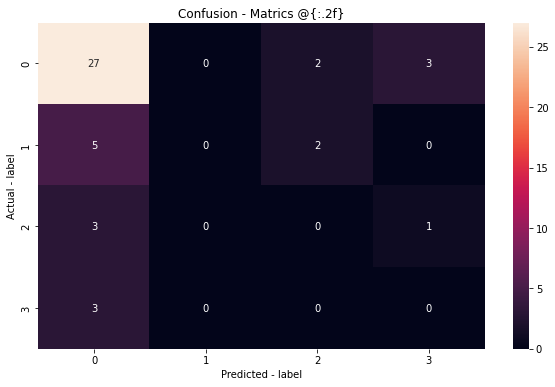

In [253]:
#confusion Matrics
plot_Confusion_Matric(Y,Y_predicted_test)